# Neural Networks

We want to train a neural Network und the Mnist Dataset on our own model. We begin by importing all the important the libraries `numpy` and `matplotlib` for tensor operations and visualizations. Then we load the dataset by our `mnist_loader`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline

# Import my modules
from mnist import load_mnist
from neuralnetwork import NeuralNetwork
from layers import Layer, Perceptron, Conv, MaxPooling, Flatten
from loss import MSE, MSE_Attention
from activation import Sigmoid, SoftMax, ReLU
from optimizer import Adam

(x_train, y_train), (x_test, y_test) = load_mnist(vectorize=True, limit=None) # 10000

### Model One
The first Model will be the one from the practical. It contains one hidden layer with 200 neurons and computes its output via $\vec{a}_t = W_t\cdot \vec{a}_{t + 1} + \vec{b}_t$. The bias vector was not specifically asked for but it felt just to crude to leave it out.

In [26]:
np.random.seed(42)

model_one = NeuralNetwork(28*28, MSE())
model_one + Perceptron(200, Sigmoid())
model_one + Perceptron(10, Sigmoid())

##### Training
Now we train the model for just one epoch on the full dataset. The hyperparameters are chosen empirically.

In [29]:
epochs = 10
batchsize = 256
η = 1e-3

history_one = model_one.SGD(x_train, y_train, epochs, batchsize, η)

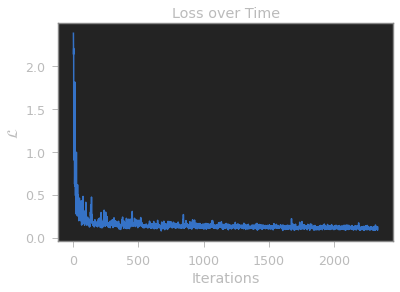

In [30]:
def plot(values, title=None, xlabel=None, ylabel=None):
    for value in values: plt.plot(range(len(value)), value)
    if title is not None: plt.title(title)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)
    plt.show()

plot([history_one['loss']], 'Loss over Time', 'Iterations', '$\mathcal{L}$')

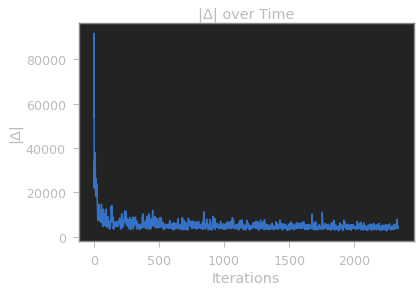

In [31]:
plot([history_one['grads']], '|Δ| over Time', 'Iterations', '|Δ|')

##### Evaluation
After just one epoch the model archieves a prediction accuracy of $90.18$%. Thats quite nice, but we can do better then this.

In [32]:
result = model_one.evaluate(x_test, y_test)

Accuracy:	90.18%
Average Loss:	0.098


> If you are looking for a solution for the practical to find an aproach or to copy it, you can stop here. The rest of this notebook is not required.

### Model Two
The second model will be a little bit more fancy.

##### Adam
First of all we will make use of some gradient descend optimization techniques. The partial derivatives of the gradient will be scaled by the Adam (Adaptive Moment Estimation) method. It keeps two state estimations on the gradients momentum $m$ and its work $v$. At each step it updates the states with the gradient $L\nabla$ with the following equations.

$$m_w^{t+1} \leftarrow \beta_1  m_w^t + (1 - \beta_1) \nabla_w L$$
$$v_w^{t+1} \leftarrow \beta_2  v_w^t + (1 - \beta_2) (\nabla_w L)^2$$

The weights will then be updated by the following equations:

$$\hat{m}_w = \frac{m_w^{t+1}}{1 - \beta_1}$$

$$\hat{v}_w = \frac{v_w^{t+1}}{1 - \beta_2}$$

$$w^{t+1} \leftarrow w^{t} - \eta \frac{\hat{m}_w}{\sqrt{\hat{m}_w}+\epsilon}$$

where $\epsilon$ is some small value like $10^{-8}$ to keep the denominator from beeing $0$ and $\beta_1$ and $\beta_2$ are the forgetting factors for the updates of $m$ and $v$.

##### SoftMax
The last layer in our models should return the probabilites for all classes. But by definition the sum over all possibilities $\sum_{\omega \in \Omega} \text{P}(\omega)=1$, which is not fulfilled by the Sigmoid function. We will therefore use the SoftMax function to normalize the final layer.

$$\sigma(x_i) = \frac{e^{x^i}}{\sum_j e^{x^j}}$$

The denominator is the same for all indicies $i$. The derivative of the SoftMax function is:

$$\frac{\partial \sigma}{\partial x} = \text{diag}(\sigma(x)) - \sigma(x)\cdot\sigma(x_i)^\mathsf{T}$$

##### ReLU
We will further introduce the Rectified Linear Unit activation function. It is quite usefull to train particular deep networks. It is often denoted $\mathsf{ReLU}(x) \dot{=} \max (0, x)$ but we will use the form:

$$\mathsf{ReLU}(x) \dot{=} \left\{\begin{matrix}{ x \quad \text{if} \quad x > 0 \\ 0 \quad \text{else} }\end{matrix} \right.$$

A common problem with $\mathsf{ReLU}$ is, that it tends to *kill* Neurons with have a to high bias that keeps its activation constantly below $0$ so that its partial derivative will never affect it. This is ommited with the $_{\mathsf{leaky}}\mathsf{ReLU}$ activation function which is defined as.

$$_{\mathsf{leaky}}\mathsf{ReLU}(x) \dot{=} \left\{\begin{matrix}{ x \quad \text{if} \quad x > 0 \\ x \cdot \lambda \quad \text{else} }\end{matrix} \right.$$

typically for a parameter $\lambda \in [0, 1)$, where $\lambda = 0$ would be equivalent to ordinary $\mathsf{ReLU}$.
Its derivatives are defined as:
$$\frac{\partial\mathsf{ReLU}}{\partial x} = \mathsf{H}(x) = \left\{\begin{matrix}{ 1 \quad \text{if} \quad x > 0 \\ 0 \quad \text{else} }\end{matrix} \right.$$

$$\frac{\partial_{\mathsf{leaky}}\mathsf{ReLU}}{\partial x} \dot{=} \left\{\begin{matrix}{ 1 \quad \text{if} \quad x > 0 \\ \lambda \quad \text{else} }\end{matrix} \right.$$

where $\mathsf{H}$ is the Heavyside function.

In [33]:
np.random.seed(42)

model_two = NeuralNetwork(28*28, MSE(), Adam(β1=0.9, β2=0.999))
model_two + Layer(384, ReLU(leaky=0.2), l2=0.3)
model_two + Layer(64, ReLU(leaky=0.2), l2=0.1)
model_two + Layer(10, Sigmoid())

Now we train the second model with empirically determined hyperparameters for one epoch.

In [41]:
epochs = 10
batchsize = 256
η = 1e-3

history_two = model_two.SGD(x_train, y_train, epochs, batchsize, η)

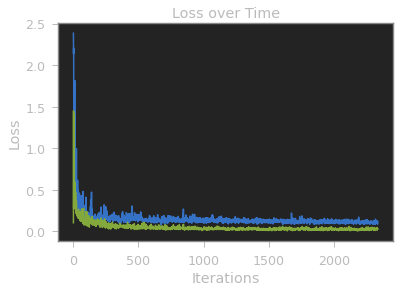

In [38]:
plot([history_one['loss'], history_two['loss']], 'Loss over Time', 'Iterations', 'Loss')

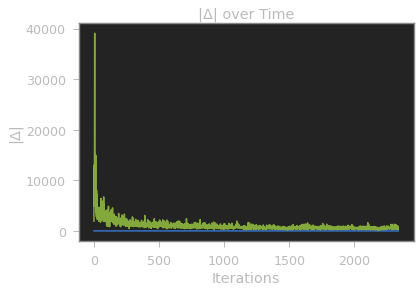

In [39]:
plot([history_one['loss'], history_two['grads']], '|Δ| over Time', 'Iterations', '|Δ|')

Now $97.48$% looks much better. We should remember here, that gaining a higher accuracy becomes asymtotically more challanging the better it gets.

In [42]:
result = model_two.evaluate(x_test, y_test)

Accuracy:	97.48%
Average Loss:	0.031


In [44]:
(x_train, y_train), (x_test, y_test) = load_mnist(vectorize=False, limit=None)

In [2]:
np.random.seed(42)

# MODEL
model_four = NeuralNetwork((28, 28, 1), MSE(), Adam(β1=0.9, β2=0.999))
# CONVOLUTION ONE
conv_0 = Conv(12, (3, 3))
model_three + conv_0
model_three + AveragePooling((2, 2), ReLU(leaky=0.1))
# CONVOLUTION TWO
conv_1 = Conv(16, (3, 3))
model_three + conv_1
model_three + AveragePooling((2, 2), ReLU(leaky=0.1))
# DENSE NETWORK
model_three + Flatten()
model_three + Layer(128, ReLU(leaky=0.1), l2=0.3)
model_three + Layer(32, ReLU(leaky=0.1), l2=0.2)
model_three + Layer(10, Sigmoid())

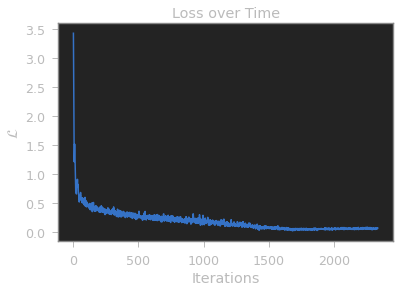

In [4]:
epochs = 10
batchsize = 256
η = 1e-2

history_three = model_three.SGD(x_train, y_train, epochs, batchsize, η)

plot([history_three['loss']], 'Loss over Time', 'Iterations', '$\mathcal{L}$')

In [24]:
model_three.evaluate(x_test, y_test)

Accuracy:	97.00%
Average Loss:	0.027


(0.97, 0.027195810674444012)

|Δ|=3967.14	Loss=0.027: 100%|██████████| 870/870 [56:48<00:00,  3.92s/it]


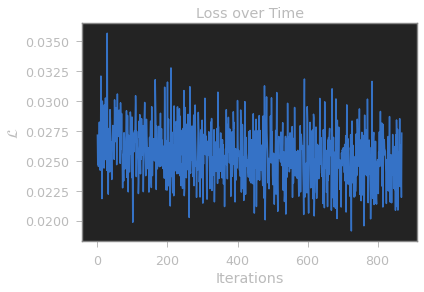

In [23]:
conv_0.trainable = False
conv_1.trainable = False

epochs = 30
batchsize = 2048
η = 1e-5

history_three_finetune = model_three.SGD(x_train, y_train, epochs, batchsize, η)

plot([history_three_finetune['loss']], 'Loss over Time', 'Iterations', '$\mathcal{L}$')

In [45]:
model_three.evaluate(x_test, y_test)

Accuracy:	97.00%
Average Loss:	0.027


(0.97, 0.027195810674444012)

### Handwritten Sample

Lets have a look at my handwriting, which is going to be a real challenge for the Model.

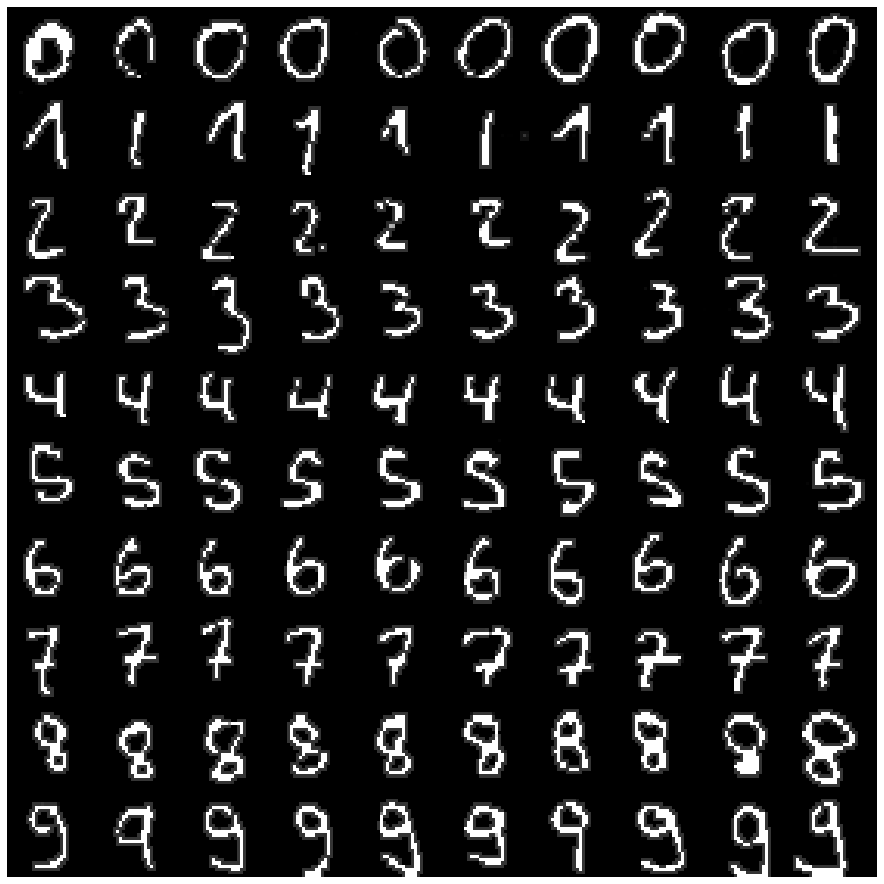

In [2]:
img = Image.open('data/handwritting_sample.png')
handwritting = -np.asarray(img)[:,:,0]
data = [[handwritting[i*28:i*28 + 28, j*28: j*28 + 28] for j in range(10)] for i in range(10)]

def visualize(array):
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(array, cmap='binary')
    plt.xticks()
    plt.show()

visualize(-handwritting)

Having a look at the mnist dataset, we can see that it differs from mine in two important ways. The first is obviously, that mine only contains my handwritting instead of a multitude of handwrittings, the second is, that mine only contains 3 pixel values for **white**, **grey** and **black**  due to the converting process that allowed me to filter out the grid from the paper I wrote the samples on.

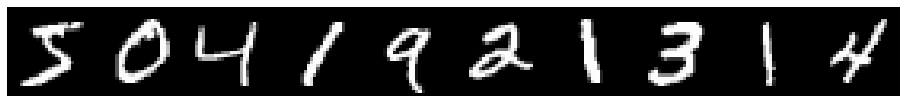

In [14]:
visualize(-np.concatenate([sample.reshape(28, 28) for sample in np.rollaxis(x_train[:,:10], axis=1)], axis=1))

Now we are going to test my sample on both models.

In [48]:
accuracy_one = sum(model_one.predict(sample.reshape(-1, 1)) == i for i, row in enumerate(data) for sample in row)
accuracy_two = sum(model_two.predict(sample.reshape(-1, 1)) == i for i, row in enumerate(data) for sample in row)
accuracy_three = sum(model_three.predict(sample.reshape(28, 28, 1, 1)) == i for i, row in enumerate(data) for sample in row)

print(f"""Comparing Accuracy on sample Data
Model One:   {accuracy_one}%
Model Two:   {accuracy_two}%
Model Three: {accuracy_three}%""")

Comparing Accuracy on sample Data
Model One:   50%
Model Two:   67%
Model Three: 66%


### Model Four
Lastly we want to make a model, that will be quite easy to visualize. Our goal is to get some insight into the Network by plotting some of the abstractions of features in the network. For our purposes the Sigmoid Activationfunction seems to be a quite reasonable choice. We will further choose 3 layers.

In [15]:
np.random.seed(42)

model_four = NeuralNetwork(28*28, MSE(), Adam(β1=0.9, β2=0.999))
model_four + Layer(384, Sigmoid(), l2=0.3)
model_four + Layer(64, Sigmoid(), l2=0.1)
model_four + Layer(10, SoftMax())

In [21]:
epochs = 10
batchsize = 256
η = 1e-3

history_four = model_four.SGD(x_train, y_train, epochs, batchsize, η)

|Δ|=7638.47	Loss=0.127: 100%|██████████| 2340/2340 [01:25<00:00, 27.26it/s] 


In [22]:
result = model_four.evaluate(x_test, y_test)

Accuracy:	82.51%
Average Loss:	0.140


# We have to go DEEPER

Neural Networks are notoriously opaque in their decision making process. Luckily for us, in the mnist case we have a local relation for the input features. That means that pixels that are close together most of the time have similar values. If we have a look at the rows of the weight matrix, we can see that each value in it corresdonds to the importance of an inputpixel for the feature that is learned by the neuron, that represents this row. We can visualize the first 64 rows by the following code.

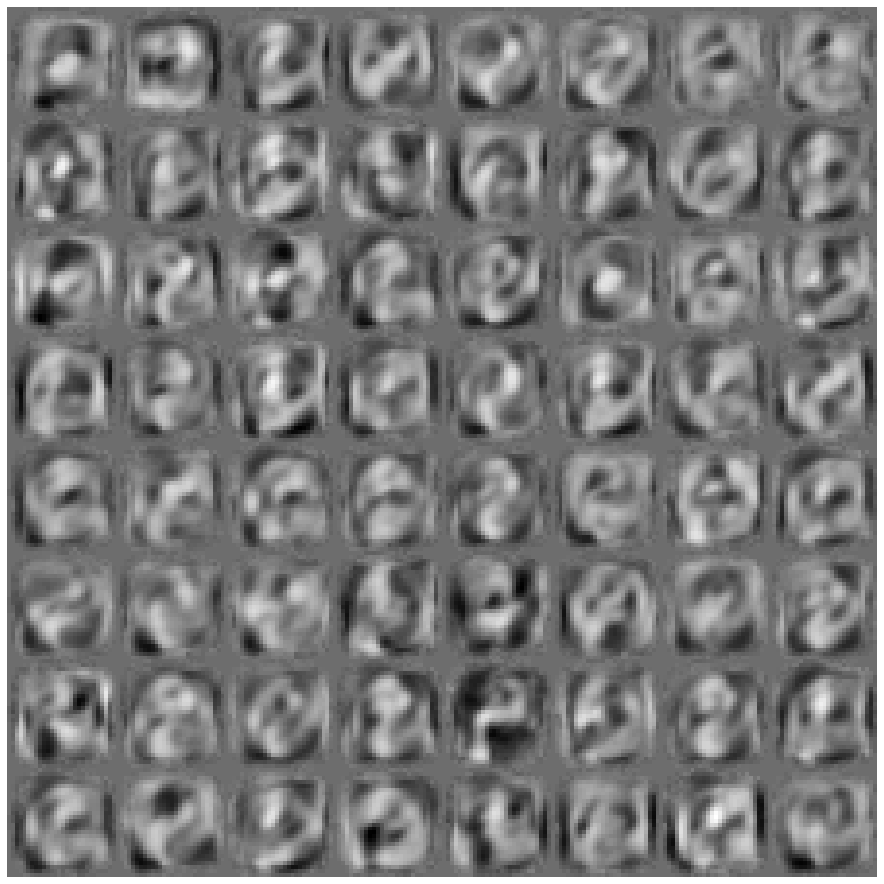

In [23]:
layer_0 = np.concatenate([np.concatenate([model_four[0].W[i*8 + j].reshape(28, 28)
                                for j in range(8)], axis=0)for i in range(8)], axis=1).T
visualize(layer_0)

We can propagate this representation through the network by multiplying the weights one after another to obtain the representations ot the following layers.

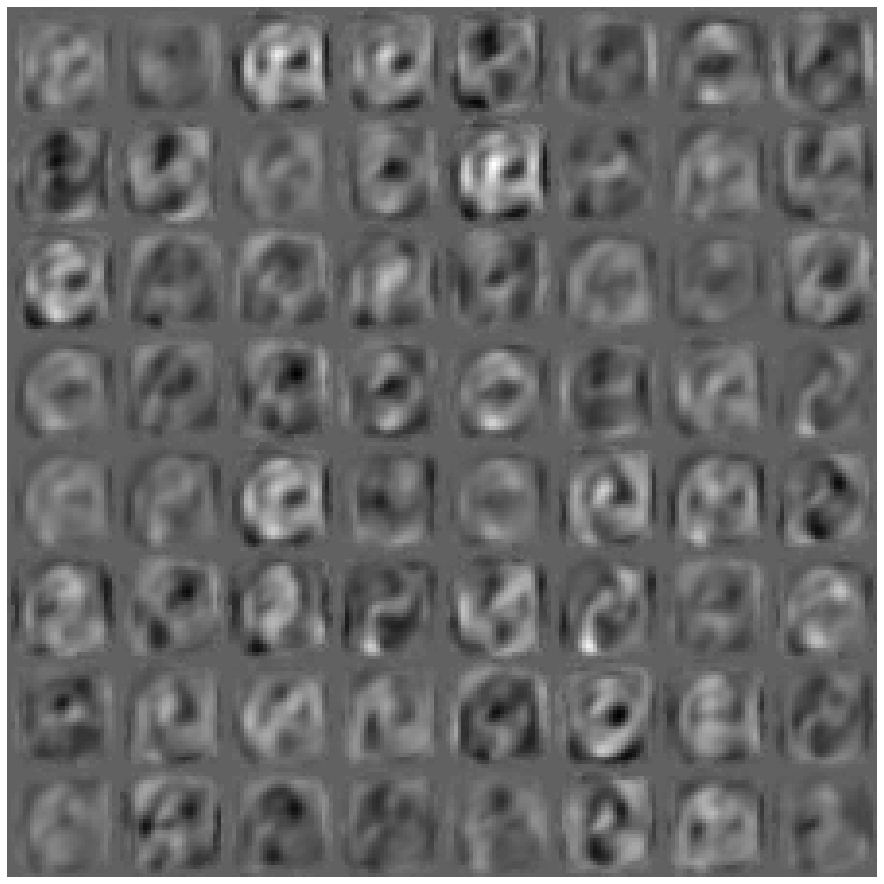

In [24]:
layer_1 = [(np.dot(model_four[0].W.T, vec)).reshape(28, 28) for i, vec in enumerate(model_four[1].W[:64])]
vis_layer_1 = np.concatenate([np.concatenate(layer_1[i:i+8], axis=0) for i in range(0, 64, 8)], axis=1).T
visualize(vis_layer_1)

Lastly we can have a look at the representations of the final classes.

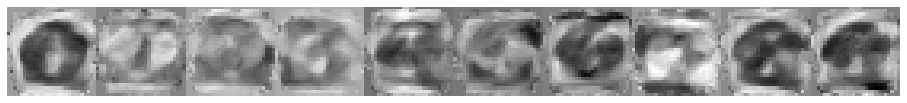

In [25]:
layer_2 = [np.dot(Sigmoid()(np.dot(model_four[0].W.T, model_four[1].W.T) 
            + model_four[1].b.T),vec).reshape(28, 28)for vec in model_four[2].W]
vis_layer_2 = np.concatenate(layer_2, axis=1)
visualize(vis_layer_2)